### Importing Libaries

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
import catboost as cb
import xgboost as xgb
import plotly.offline as pyo
import plotly.graph_objs as go
from scipy import stats
from sklearn.ensemble import RandomForestRegressor

### Importing Dataset

In [101]:
train=pd.read_csv("train_6BJx641.csv")
test=pd.read_csv("test_pavJagI.csv")

### Creating Functions

In [102]:
def datetime(data):
    data["datetime"]=pd.to_datetime(data["datetime"],format="%Y-%m-%d %H:%M:%S")
    data["year"]=data["datetime"].dt.year
    data["month"]=data["datetime"].dt.month
    data["day"]=data["datetime"].dt.day
    data["dow"]=data["datetime"].dt.dayofweek
    data["hour"]=data["datetime"].dt.hour
    data["weekend"]=data["dow"].apply(lambda x:1 if x in [5,6] else 0)
    data["imp_month"]=data["month"].apply(lambda x:1 if x in [7,8] else 0)
    return data

In [103]:
def grp_fun(data):    
    month_hour_grp=train_df.groupby(['month',"hour"]).agg({"electricity_consumption":["mean","median"]}).reset_index()
    month_hour_grp.columns=["month","hour","mean","median"]
    data=pd.merge(left=data,right=month_hour_grp,on=["month","hour"],how="left")
    return data

In [104]:
train_df=datetime(train)
test_df=datetime(test)

train_df=grp_fun(train_df)
test_df=grp_fun(test_df)

### Concating Dataset

In [105]:
train_df["Data"]="Train"
test_df["Data"]="Test"
df=pd.concat([train_df,test_df])
#Binning Numerical Values:
df["temperature_bin"]=pd.qcut(df["temperature"],5,labels=[1,2,3,4,5]).astype(int)
df["pressure_bin"]=pd.qcut(df["pressure"],5,labels=[1,2,3,4,5]).astype(int)
df["windspeed_bin"]=pd.qcut(df["windspeed"],5,labels=[1,2,3,4,5]).astype(int)
df["var1_bin"]=pd.qcut(df["var1"],5,labels=[1,2,3,4,5]).astype(int)

In [106]:
df_dummies=df.copy()
df_dummies=df_dummies.sort_values(by="datetime")
#taking lag of target variable:
df_dummies["lag"]=df_dummies["electricity_consumption"].shift(1)
df_dummies=df_dummies.drop(columns=["datetime","ID"])
df_dummies["var2"]=df_dummies["var2"].map({"A":0,"B":1,"C":2})
train_final=df_dummies[df_dummies["Data"]=="Train"]
test_final=df_dummies[df_dummies["Data"]=="Test"]
train_final=train_final.drop(columns=["Data"])
test_final=test_final.drop(columns=["Data","electricity_consumption"])

In [107]:
#Dropping Null Values:
train_final.dropna(inplace=True)
X=train_final.drop(columns=["electricity_consumption"])
y=train_final["electricity_consumption"]
model=lgb.LGBMRegressor()
results=cross_val_score(estimator=model,X=X,y=y,cv=3,scoring="neg_mean_squared_error",n_jobs=-1)
(results*-1).mean()**.5

31.33842083054605

**We have a good score but the test data doesn't lag column.**

In [94]:
model.fit(X,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

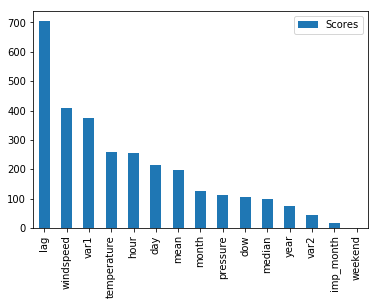

In [95]:
pd.DataFrame(data=model.feature_importances_,index=X.columns,
             columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.bar()

#### Numerical columns seems to be important variables as they seem to very high correlation with target.

In [96]:
#stacking lightgbm and catboost models:
lgb_model=lgb.LGBMRegressor().fit(X,y)
cat_model=cb.CatBoostRegressor().fit(X,y)

0:	learn: 105.5021739	total: 14.4ms	remaining: 14.4s
1:	learn: 103.1397749	total: 22.3ms	remaining: 11.1s
2:	learn: 100.8018265	total: 28.6ms	remaining: 9.5s
3:	learn: 98.5471988	total: 35ms	remaining: 8.71s
4:	learn: 96.4478250	total: 44.5ms	remaining: 8.85s
5:	learn: 94.2644590	total: 52.1ms	remaining: 8.64s
6:	learn: 92.2183877	total: 58.8ms	remaining: 8.35s
7:	learn: 90.3138540	total: 65.2ms	remaining: 8.08s
8:	learn: 88.3764401	total: 71.4ms	remaining: 7.87s
9:	learn: 86.5547868	total: 78.9ms	remaining: 7.81s
10:	learn: 84.7764902	total: 85.8ms	remaining: 7.71s
11:	learn: 83.0496573	total: 92.4ms	remaining: 7.61s
12:	learn: 81.3736250	total: 98.8ms	remaining: 7.5s
13:	learn: 79.7767977	total: 105ms	remaining: 7.42s
14:	learn: 78.2282389	total: 112ms	remaining: 7.32s
15:	learn: 76.7842309	total: 120ms	remaining: 7.37s
16:	learn: 75.3477214	total: 126ms	remaining: 7.29s
17:	learn: 73.9846755	total: 132ms	remaining: 7.2s
18:	learn: 72.6936203	total: 139ms	remaining: 7.16s
19:	learn: 

176:	learn: 39.8509663	total: 1.25s	remaining: 5.79s
177:	learn: 39.8338601	total: 1.25s	remaining: 5.79s
178:	learn: 39.8246330	total: 1.26s	remaining: 5.79s
179:	learn: 39.8064337	total: 1.27s	remaining: 5.78s
180:	learn: 39.7891266	total: 1.27s	remaining: 5.77s
181:	learn: 39.7780632	total: 1.28s	remaining: 5.76s
182:	learn: 39.7601984	total: 1.29s	remaining: 5.76s
183:	learn: 39.7530492	total: 1.3s	remaining: 5.75s
184:	learn: 39.7384320	total: 1.3s	remaining: 5.74s
185:	learn: 39.7242332	total: 1.31s	remaining: 5.73s
186:	learn: 39.7161355	total: 1.32s	remaining: 5.73s
187:	learn: 39.7029570	total: 1.32s	remaining: 5.72s
188:	learn: 39.6728213	total: 1.33s	remaining: 5.71s
189:	learn: 39.6561840	total: 1.34s	remaining: 5.7s
190:	learn: 39.6467103	total: 1.34s	remaining: 5.69s
191:	learn: 39.6328898	total: 1.35s	remaining: 5.68s
192:	learn: 39.6214102	total: 1.36s	remaining: 5.68s
193:	learn: 39.6093988	total: 1.36s	remaining: 5.67s
194:	learn: 39.5949172	total: 1.37s	remaining: 5.

353:	learn: 38.0038680	total: 2.65s	remaining: 4.84s
354:	learn: 37.9972576	total: 2.66s	remaining: 4.83s
355:	learn: 37.9896310	total: 2.67s	remaining: 4.82s
356:	learn: 37.9732575	total: 2.67s	remaining: 4.81s
357:	learn: 37.9664315	total: 2.68s	remaining: 4.8s
358:	learn: 37.9583441	total: 2.69s	remaining: 4.8s
359:	learn: 37.9474342	total: 2.69s	remaining: 4.79s
360:	learn: 37.9423368	total: 2.7s	remaining: 4.78s
361:	learn: 37.9343102	total: 2.71s	remaining: 4.77s
362:	learn: 37.9222819	total: 2.71s	remaining: 4.76s
363:	learn: 37.9082431	total: 2.72s	remaining: 4.75s
364:	learn: 37.8956923	total: 2.72s	remaining: 4.74s
365:	learn: 37.8849099	total: 2.73s	remaining: 4.74s
366:	learn: 37.8781505	total: 2.74s	remaining: 4.73s
367:	learn: 37.8722133	total: 2.75s	remaining: 4.73s
368:	learn: 37.8672778	total: 2.76s	remaining: 4.72s
369:	learn: 37.8561327	total: 2.77s	remaining: 4.72s
370:	learn: 37.8450527	total: 2.78s	remaining: 4.72s
371:	learn: 37.8396047	total: 2.79s	remaining: 4.

511:	learn: 36.7754676	total: 3.69s	remaining: 3.52s
512:	learn: 36.7750348	total: 3.7s	remaining: 3.51s
513:	learn: 36.7675672	total: 3.7s	remaining: 3.5s
514:	learn: 36.7617984	total: 3.71s	remaining: 3.5s
515:	learn: 36.7563444	total: 3.72s	remaining: 3.49s
516:	learn: 36.7481912	total: 3.72s	remaining: 3.48s
517:	learn: 36.7424823	total: 3.73s	remaining: 3.47s
518:	learn: 36.7326099	total: 3.74s	remaining: 3.46s
519:	learn: 36.7266237	total: 3.74s	remaining: 3.46s
520:	learn: 36.7195653	total: 3.75s	remaining: 3.45s
521:	learn: 36.7124885	total: 3.76s	remaining: 3.44s
522:	learn: 36.7054693	total: 3.76s	remaining: 3.43s
523:	learn: 36.6961093	total: 3.77s	remaining: 3.42s
524:	learn: 36.6926130	total: 3.78s	remaining: 3.42s
525:	learn: 36.6840562	total: 3.78s	remaining: 3.41s
526:	learn: 36.6838527	total: 3.79s	remaining: 3.4s
527:	learn: 36.6798836	total: 3.8s	remaining: 3.39s
528:	learn: 36.6796881	total: 3.8s	remaining: 3.39s
529:	learn: 36.6732322	total: 3.81s	remaining: 3.38s


681:	learn: 35.8483099	total: 5.68s	remaining: 2.65s
682:	learn: 35.8454119	total: 5.69s	remaining: 2.64s
683:	learn: 35.8453139	total: 5.69s	remaining: 2.63s
684:	learn: 35.8410169	total: 5.7s	remaining: 2.62s
685:	learn: 35.8378242	total: 5.72s	remaining: 2.62s
686:	learn: 35.8340230	total: 5.74s	remaining: 2.61s
687:	learn: 35.8278302	total: 5.75s	remaining: 2.61s
688:	learn: 35.8184132	total: 5.77s	remaining: 2.6s
689:	learn: 35.8183108	total: 5.78s	remaining: 2.59s
690:	learn: 35.8182103	total: 5.78s	remaining: 2.58s
691:	learn: 35.8094493	total: 5.79s	remaining: 2.58s
692:	learn: 35.8041183	total: 5.8s	remaining: 2.57s
693:	learn: 35.7982667	total: 5.81s	remaining: 2.56s
694:	learn: 35.7951695	total: 5.81s	remaining: 2.55s
695:	learn: 35.7928468	total: 5.82s	remaining: 2.54s
696:	learn: 35.7871150	total: 5.84s	remaining: 2.54s
697:	learn: 35.7870140	total: 5.85s	remaining: 2.53s
698:	learn: 35.7834578	total: 5.86s	remaining: 2.52s
699:	learn: 35.7777293	total: 5.87s	remaining: 2.

842:	learn: 35.1270235	total: 7.1s	remaining: 1.32s
843:	learn: 35.1203848	total: 7.11s	remaining: 1.31s
844:	learn: 35.1203150	total: 7.11s	remaining: 1.3s
845:	learn: 35.1202448	total: 7.12s	remaining: 1.29s
846:	learn: 35.1132502	total: 7.13s	remaining: 1.29s
847:	learn: 35.1101152	total: 7.13s	remaining: 1.28s
848:	learn: 35.1059775	total: 7.14s	remaining: 1.27s
849:	learn: 35.1002054	total: 7.15s	remaining: 1.26s
850:	learn: 35.0942192	total: 7.15s	remaining: 1.25s
851:	learn: 35.0941439	total: 7.16s	remaining: 1.24s
852:	learn: 35.0897438	total: 7.17s	remaining: 1.23s
853:	learn: 35.0896487	total: 7.17s	remaining: 1.23s
854:	learn: 35.0871212	total: 7.18s	remaining: 1.22s
855:	learn: 35.0870539	total: 7.18s	remaining: 1.21s
856:	learn: 35.0803409	total: 7.19s	remaining: 1.2s
857:	learn: 35.0802739	total: 7.2s	remaining: 1.19s
858:	learn: 35.0763782	total: 7.21s	remaining: 1.18s
859:	learn: 35.0759824	total: 7.21s	remaining: 1.17s
860:	learn: 35.0759160	total: 7.22s	remaining: 1.1

#### We will use the predictions to replace the lag in the next row.But,this will decrease the rmse value towards the month end.

In [97]:
val=[]
test_change=test_final.copy()
for i in range(len(test_change)):
    if pd.isnull(test_change.iloc[i]["lag"]):
        test_change.iloc[i]=test_change.iloc[i].fillna(val[i-1][0])
        predictions=lgb_model.predict(test_change.iloc[i].values.reshape(1,-1))
        val.append(predictions)
    else:
        predictions=lgb_model.predict(test_change.iloc[i].values.reshape(1,-1))
        val.append(predictions)
lgb_pred=[i[0] for i in val]

In [98]:
test_change=test_final.copy()
val=[]
for i in range(len(test_final)):
    if pd.isnull(test_change.iloc[i]["lag"]):
        test_change.iloc[i]=test_change.iloc[i].fillna(val[i-1][0])
        predictions=cat_model.predict(test_change.iloc[i].values.reshape(1,-1))
        val.append(predictions)
    else:
        predictions=cat_model.predict(test_change.iloc[i].values.reshape(1,-1))
        val.append(predictions)

cat_pred=[i[0] for i in val]

In [99]:
pred=[(cat_pred[i]+lgb_pred[i])/2 for i in range(len(cat_pred))]

sub=pd.read_csv("sample_submission_bYgKb77.csv")

sub["electricity_consumption"]=cat_pred

sub.to_csv("sub9.csv",index=False)

### Finished 10th in  private leaderboard with 88.07 